# Individual Assignment

Dataset: "NYU Slow Flanker" dataset from [OpenNeuro](https://openneuro.org/datasets/ds000102/versions/00001). 

1. **Setting up environment**
    - Setting up a directory structure
    - Define experiment variables 
2. **Preprocessing** using Nipype Nodes
	- Removing the first 4 volumes
	- Slicetime correction
	- Realignment (Motion Correction)
	- Coregistration of anatomical and functional image (using a pre-defined sub-workflow)
	- Normalization to the MNI template (using a pre-defined sub-workflow)
	- Smoothing
3. **Sanity checks** 
	- Plot output files
	- Inspect motion parameters and detected artefacts
4. **First-level analysis** using Nilearn

## Setting up the environment

- Create directories
- Install dependencies (i.e., Nipype, Nilearn, FSL)
- Download data

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
import os
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt
from matplotlib import patches
from nipype.interfaces import fsl
from nipype.algorithms.rapidart import ArtifactDetect
from os.path import abspath
import json


project_root_dir = os.getcwd()
fslpath = os.environ["FSLDIR"]

os.makedirs("data", exist_ok=True)
os.makedirs("output/working_dir", exist_ok=True)
os.makedirs(fslpath + "/data/standard", exist_ok=True)

### Download MNI Atlas

In [3]:
# add mni template to fsl dir
# os.makedirs(fslpath + "/data/standard", exist_ok=True)
# !wget 'https://ucloud.univie.ac.at/index.php/s/bnj6HPWqImlpFjD/download' -O ~/Downloads/mniatlas.zip
# !unzip -oq ~/Downloads/mniatlas.zip -d ${FSLDIR}/data/standard

### Download dataset

In [4]:
# !gdown 1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ
# !unzip ./ds000102.zip -d ./data

### Experiment parameters

In [5]:
# set paths for experiment dir, working dir and output dir
working_dir = project_root_dir + "/output/working_dir"
data_dir = project_root_dir + "/data/ds000102"
output_dir = project_root_dir + "/output"

test_subj = "sub-02"

test_anat = f"{data_dir}/{test_subj}/anat/{test_subj}_T1w.nii.gz"
test_func = f"{data_dir}/{test_subj}/func/{test_subj}_task-flanker_run-1_bold.nii.gz"
test_func2 = f"{data_dir}/{test_subj}/func/{test_subj}_task-flanker_run-2_bold.nii.gz"

### Inspect Data

In [6]:
anat = nib.load(test_anat)
func = nib.load(test_func)


anat_data = anat.get_fdata()
func_data = func.get_fdata()[:, :, :, 4:]


# check the shape of the files
print("shape of anat file:", anat_data.shape)
print("shape of func file:", func_data.shape)

print(
    f"\nWe have {func_data.shape[2]} slices with a resolution of {func_data.shape[0]}x{func_data.shape[1]} voxels and {func_data.shape[3]} timepoints"
)

shape of anat file: (176, 256, 256)
shape of func file: (64, 64, 40, 142)

We have 40 slices with a resolution of 64x64 voxels and 142 timepoints


In [7]:
with open(data_dir + "/task-flanker_bold.json", "rt") as fp:
    task_info = json.load(fp)
TR = task_info["RepetitionTime"]
TA = TR - (TR / func_data.shape[2])

#### Plot of anatomical image

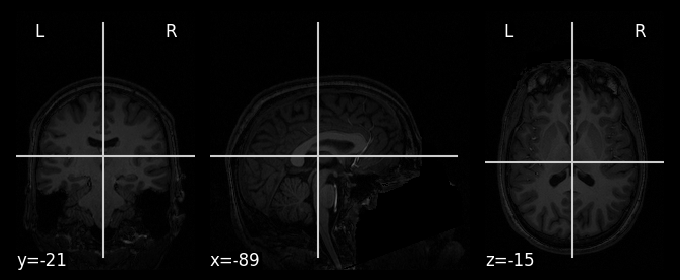

In [8]:
plotting.plot_anat(anat);

#### Plot of functional image

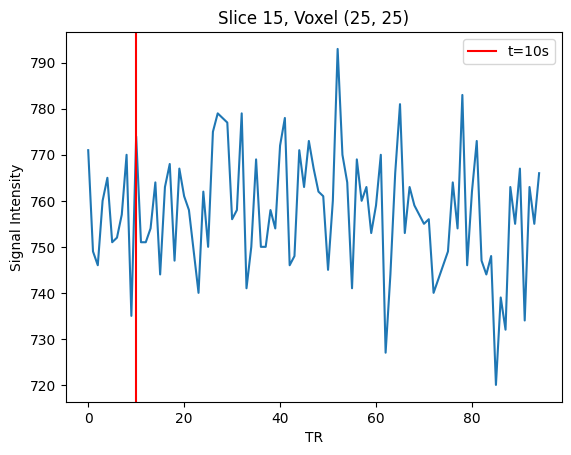

In [9]:
# define variables for number of slices, tr and ta

slice_no = 15
voxel_x = 25
voxel_y = 25

timepoints = slice(5, 100)
timepoint = 10

plt.plot(func_data[slice_no, voxel_x, voxel_y, timepoints])
plt.axvline(timepoint, color="red", label=f"t={timepoint}s")
plt.xlabel("TR")
plt.ylabel("Signal Intensity")
plt.title(f"Slice {slice_no}, Voxel {(voxel_x, voxel_y)}")
plt.legend();

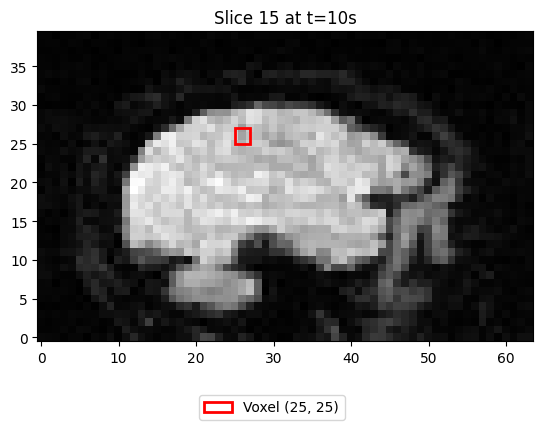

In [10]:
fig, ax = plt.subplots()
ax.imshow(func_data[slice_no, :, :, timepoint].T, cmap="gray", origin="lower")
rect = patches.Rectangle(
    (voxel_x, voxel_y),
    2,
    2,
    linewidth=2,
    edgecolor="r",
    facecolor="none",
    label=f"Voxel {(voxel_x, voxel_y)}",
)
ax.add_patch(rect)
ax.set_title(f"Slice {slice_no} at t={timepoint}s")
fig.legend(loc="lower center");

<div class="alert alert-info">everything looks alright</div>

## Preprocessing / Input/Output Stream

### Define Nodes

In [11]:
from nipype import Node, Workflow
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.fsl.utils import ExtractROI

templates = {
    "anat": f"{test_subj}/anat/{test_subj}_T1w.nii.gz",
    "func": f"{test_subj}/func/{test_subj}_task-flanker_run-1_bold.nii.gz",
}

# File Input
selectfiles = Node(
    SelectFiles(templates, base_directory=data_dir, sort_filelist=True),
    name="selectfiles",
)

# remove first four volumes
extract_roi = Node(
    ExtractROI(crop_list=[(0, -1), (0, -1), (0, -1), (4, -1)]), name="extract_roi"
)

# Skullstrip Node
strip_skull = Node(fsl.BET(in_file=test_anat, mask=True), name="strip_skull")

# Segmentation Node
segment = Node(fsl.FAST(), name="segment")

# Slicetimer node
slicetimer = Node(
    fsl.SliceTimer(in_file=test_func, time_repetition=TR, interleaved=True),
    name="slicetimer",
)

# Realign node
realigner = Node(fsl.MCFLIRT(mean_vol=False, save_plots=True), name="realigner")

# Smoothing Node
smoother = Node(fsl.IsotropicSmooth(fwhm=4), name="smoother")

# artefact detector Node
detector = Node(
    ArtifactDetect(
        norm_threshold=2,
        zintensity_threshold=3,
        mask_type="spm_global",
        parameter_source="FSL",
        use_differences=[True, False],
        plot_type="svg",
    ),
    name="ad",
)

# File output
datasink = Node(DataSink(base_directory=output_dir), name="datasink")

### Coregistration & Normalization

For the coregistration (i.e., aligning the functional and antomical image) and the normalization (i.e., warping our data to the MNI template), we will create a sub-worflow that will be included in the main workflow. To limit the complexity of the assignment (the FSL implementation of coregistration and normalization tends to be rather complicated), we provide you with function that generate pre-defined workflows (```create_fsl_coregflow``` and ```create_fsl_normflow```, respectively). You can have a look at the functions on our [GitHub repository](https://github.com/lrsktr/tewa-neuroimaging/blob/main/Individual-and-team-projects/scripts/fsl-spatial-preproc.py)

Your task is to connect these sub-workflows with the main workflow.

*If you want to make a deep-dive into spatial preprocessing steps, check out this [notebook on coregistration and normalization](https://colab.research.google.com/github/ljchang/dartbrains/blob/master/content/Preprocessing.ipynb#scrollTo=yJAF3Lrujyrg) by [Luke Chang](http://lukejchang.com/) and colleagues from the Dartmouth College (they cover the mathematical basics of these preprocessing steps and demonstrate how to implement them using [fmriprep](https://fmriprep.readthedocs.io/) - a pipeline built on top of Nipype*.

In [12]:
# install scripts for coreg and normalization workflow
#!wget -O fslspatial.py https://ucloud.univie.ac.at/index.php/s/zVLcnufuQDbTMgI/download

In [13]:
# import custom coregistration and normalization scripts
from fslspatial import create_fsl_coregflow, create_fsl_normflow

mni_template = os.path.join(
    os.getenv("FSLDIR"), "data/standard/MNI152_T1_2mm_brain.nii.gz"
)

coreg_wf = create_fsl_coregflow(base_directory=working_dir, apply_to_epis=True)

norm_wf = create_fsl_normflow(base_directory=working_dir, reference=mni_template)

Running the functions will create two sub-workflows. We will visualize them so you get an overall idea and know how the nodes are named:

221204-15:16:39,938 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).



Coregistration Workflow:


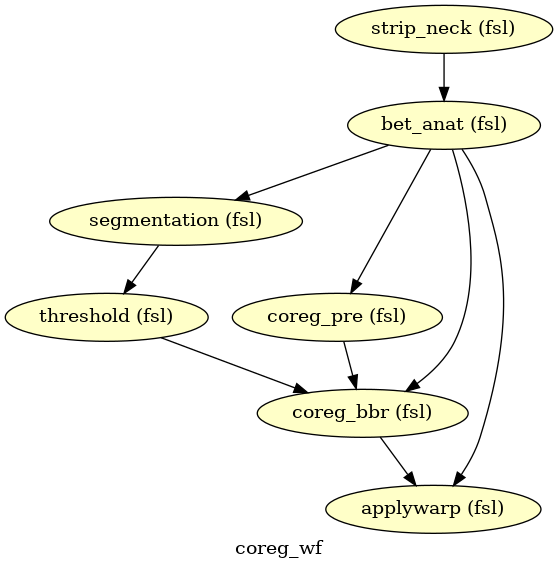

In [14]:
from IPython.display import Image

coreg_wf.write_graph(graph2use="colored", format="png", simple_form=True)

print("\nCoregistration Workflow:")
Image(filename=f"{working_dir}/{coreg_wf}/graph.png")

221204-15:16:40,435 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/working_dir/coreg_wf/graph.png (graph2use=flat, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/working_dir/coreg_wf/graph.png (graph2use=flat, simple_form=True).



Coregistration Workflow:


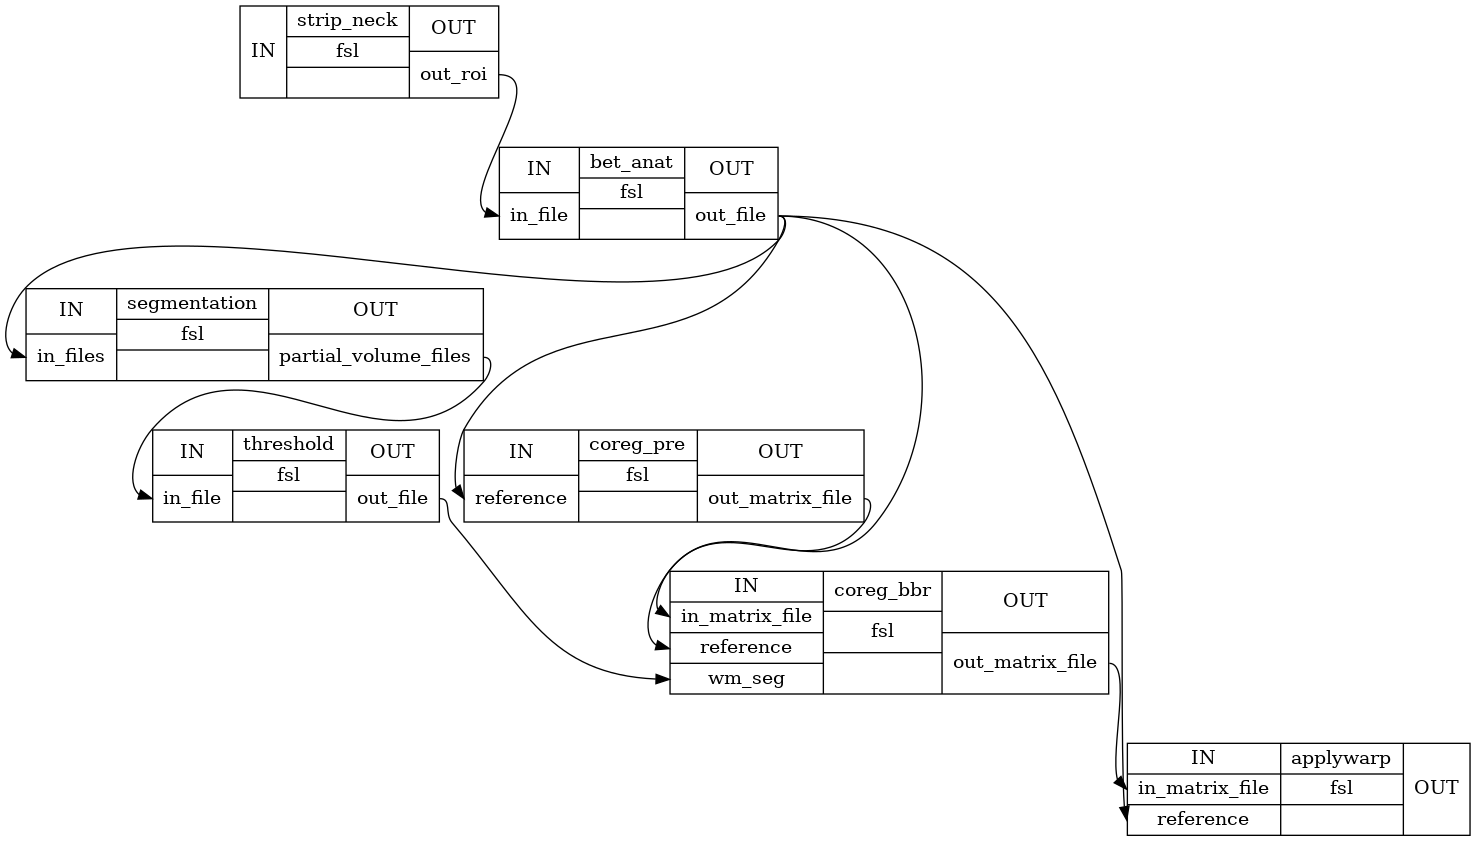

In [15]:
# Visualize the detailed graph

coreg_wf.write_graph(graph2use="flat", format="png", simple_form=True)

print("\nCoregistration Workflow:")
Image(filename=f"{working_dir}/{coreg_wf}/graph_detailed.png")

Normalization Workflow:
221204-15:16:40,653 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/working_dir/norm_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/working_dir/norm_wf/graph.png (graph2use=colored, simple_form=True).


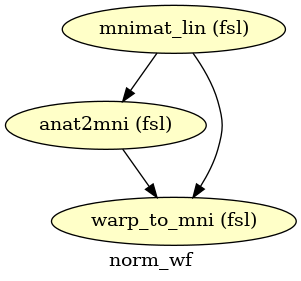

In [16]:
print("Normalization Workflow:")
norm_wf.write_graph(graph2use="colored", format="png", simple_form=True)
Image(filename=f"{working_dir}/{norm_wf}/graph.png")

221204-15:16:41,81 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/working_dir/norm_wf/graph.png (graph2use=flat, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/working_dir/norm_wf/graph.png (graph2use=flat, simple_form=True).


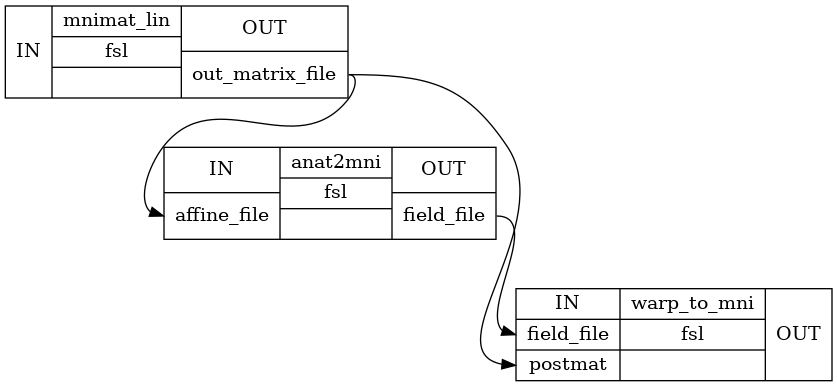

In [17]:
norm_wf.write_graph(graph2use="flat", format="png", simple_form=True)
Image(filename=f"{working_dir}/{norm_wf}/graph_detailed.png")

### Connect Nodes

Finally, the nodes have to be connected with each other. Again, to limit complexity, the comments below provide some guidance. We will also discuss this in the practicals. 

To connect the main workflow with the subworkflow, you will need to use a special syntax (see the cell below or refer to notebook 04 for an example). To get the names of coregistration and normalization nodes, refer to the graphs above.

In [18]:
wf = Workflow(name="test_workflow", base_dir=working_dir)

wf.connect(
    [
        (selectfiles, extract_roi, [("func", "in_file")]),
        (extract_roi, slicetimer, [("roi_file", "in_file")]),
        (slicetimer, realigner, [("slice_time_corrected_file", "in_file")]),
        (
            realigner,
            detector,
            [("out_file", "realigned_files"), ("par_file", "realignment_parameters")],
        ),
        (selectfiles, coreg_wf, [("anat", "strip_neck.in_file")]),
        (
            realigner,
            coreg_wf,
            [
                ("mean_img", "coreg_pre.in_file"),
                ("mean_img", "coreg_bbr.in_file"),
                ("out_file", "applywarp.in_file"),
            ],
        ),
        (
            coreg_wf,
            norm_wf,
            [
                ("segmentation.restored_image", "mnimat_lin.in_file"),
                ("segmentation.restored_image", "anat2mni.in_file"),
                ("applywarp.out_file", "warp_to_mni.in_file"),
            ],
        ),
        (norm_wf, smoother, [("warp_to_mni.out_file", "in_file")]),
        (realigner, datasink, [("par_file", "datasink.@params")]),
        (
            norm_wf,
            datasink,
            [
                ("warp_to_mni.out_file", "datasink.@warped_to_mni"),
                ("anat2mni.warped_file", "datasink.@_file"),
            ],
        ),
        (smoother, datasink, [("out_file", "datasink.@smoothed_warped_to_mni")]),
        (
            coreg_wf,
            datasink,
            [
                ("bet_anat.out_file", "datasink.@skullstripped_anat_image"),
                ("applywarp.out_file", "datasink.@applied_warped_to_anat#"),
            ],
        ),
        (
            detector,
            datasink,
            [
                ("outlier_files", "datasink.@artifact_outliers"),
                ("plot_files", "datasink.@artifact_plots"),
            ],
        ),
    ]
)

### Run workflow

In [19]:
wf.run()

221204-15:16:59,612 nipype.workflow INFO:
	 Workflow test_workflow settings: ['check', 'execution', 'logging', 'monitoring']


INFO:nipype.workflow:Workflow test_workflow settings: ['check', 'execution', 'logging', 'monitoring']


221204-15:16:59,628 nipype.workflow INFO:
	 Running serially.


INFO:nipype.workflow:Running serially.


221204-15:16:59,630 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.selectfiles" in "/work/assignments/output/working_dir/test_workflow/selectfiles".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.selectfiles" in "/work/assignments/output/working_dir/test_workflow/selectfiles".


221204-15:16:59,633 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


INFO:nipype.workflow:[Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


221204-15:16:59,637 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.00105s.


INFO:nipype.workflow:[Node] Finished "selectfiles", elapsed time 0.00105s.


221204-15:16:59,644 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.extract_roi" in "/work/assignments/output/working_dir/test_workflow/extract_roi".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.extract_roi" in "/work/assignments/output/working_dir/test_workflow/extract_roi".


221204-15:16:59,681 nipype.workflow INFO:
	 [Node] Executing "extract_roi" <nipype.interfaces.fsl.utils.ExtractROI>


INFO:nipype.workflow:[Node] Executing "extract_roi" <nipype.interfaces.fsl.utils.ExtractROI>


221204-15:17:04,733 nipype.workflow INFO:
	 [Node] Finished "extract_roi", elapsed time 5.04969s.


INFO:nipype.workflow:[Node] Finished "extract_roi", elapsed time 5.04969s.


221204-15:17:04,739 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.coreg_wf.strip_neck" in "/work/assignments/output/working_dir/test_workflow/coreg_wf/strip_neck".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.coreg_wf.strip_neck" in "/work/assignments/output/working_dir/test_workflow/coreg_wf/strip_neck".


221204-15:17:04,745 nipype.workflow INFO:
	 [Node] Executing "strip_neck" <nipype.interfaces.fsl.utils.RobustFOV>


INFO:nipype.workflow:[Node] Executing "strip_neck" <nipype.interfaces.fsl.utils.RobustFOV>


221204-15:17:08,607 nipype.interface INFO:
	 stdout 2022-12-04T15:17:08.607518:Final FOV is: 


INFO:nipype.interface:stdout 2022-12-04T15:17:08.607518:Final FOV is: 


221204-15:17:08,609 nipype.interface INFO:
	 stdout 2022-12-04T15:17:08.607518:0.000000 176.000000 0.000000 256.000000 21.000000 170.000000 


INFO:nipype.interface:stdout 2022-12-04T15:17:08.607518:0.000000 176.000000 0.000000 256.000000 21.000000 170.000000 


221204-15:17:08,610 nipype.interface INFO:
	 stdout 2022-12-04T15:17:08.607518:


INFO:nipype.interface:stdout 2022-12-04T15:17:08.607518:


221204-15:17:08,717 nipype.workflow INFO:
	 [Node] Finished "strip_neck", elapsed time 3.9689389999999998s.


INFO:nipype.workflow:[Node] Finished "strip_neck", elapsed time 3.9689389999999998s.


221204-15:17:08,724 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.slicetimer" in "/work/assignments/output/working_dir/test_workflow/slicetimer".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.slicetimer" in "/work/assignments/output/working_dir/test_workflow/slicetimer".


221204-15:17:08,732 nipype.workflow INFO:
	 [Node] Executing "slicetimer" <nipype.interfaces.fsl.preprocess.SliceTimer>


INFO:nipype.workflow:[Node] Executing "slicetimer" <nipype.interfaces.fsl.preprocess.SliceTimer>


221204-15:17:20,704 nipype.workflow INFO:
	 [Node] Finished "slicetimer", elapsed time 11.966622s.


INFO:nipype.workflow:[Node] Finished "slicetimer", elapsed time 11.966622s.


221204-15:17:20,711 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.coreg_wf.bet_anat" in "/work/assignments/output/working_dir/test_workflow/coreg_wf/bet_anat".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.coreg_wf.bet_anat" in "/work/assignments/output/working_dir/test_workflow/coreg_wf/bet_anat".


221204-15:17:20,719 nipype.workflow INFO:
	 [Node] Executing "bet_anat" <nipype.interfaces.fsl.preprocess.BET>


INFO:nipype.workflow:[Node] Executing "bet_anat" <nipype.interfaces.fsl.preprocess.BET>


221204-15:17:23,475 nipype.workflow INFO:
	 [Node] Finished "bet_anat", elapsed time 2.751578s.


INFO:nipype.workflow:[Node] Finished "bet_anat", elapsed time 2.751578s.


221204-15:17:23,483 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.realigner" in "/work/assignments/output/working_dir/test_workflow/realigner".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.realigner" in "/work/assignments/output/working_dir/test_workflow/realigner".


221204-15:17:23,490 nipype.workflow INFO:
	 [Node] Executing "realigner" <nipype.interfaces.fsl.preprocess.MCFLIRT>


INFO:nipype.workflow:[Node] Executing "realigner" <nipype.interfaces.fsl.preprocess.MCFLIRT>


221204-15:17:53,667 nipype.workflow INFO:
	 [Node] Finished "realigner", elapsed time 30.172946s.


INFO:nipype.workflow:[Node] Finished "realigner", elapsed time 30.172946s.


221204-15:17:53,674 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.coreg_wf.segmentation" in "/work/assignments/output/working_dir/test_workflow/coreg_wf/segmentation".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.coreg_wf.segmentation" in "/work/assignments/output/working_dir/test_workflow/coreg_wf/segmentation".


221204-15:17:53,682 nipype.workflow INFO:
	 [Node] Executing "segmentation" <nipype.interfaces.fsl.preprocess.FAST>


INFO:nipype.workflow:[Node] Executing "segmentation" <nipype.interfaces.fsl.preprocess.FAST>


221204-15:21:10,140 nipype.workflow INFO:
	 [Node] Finished "segmentation", elapsed time 196.455188s.


INFO:nipype.workflow:[Node] Finished "segmentation", elapsed time 196.455188s.


221204-15:21:10,148 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.ad" in "/work/assignments/output/working_dir/test_workflow/ad".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.ad" in "/work/assignments/output/working_dir/test_workflow/ad".


221204-15:21:10,156 nipype.workflow INFO:
	 [Node] Executing "ad" <nipype.algorithms.rapidart.ArtifactDetect>


INFO:nipype.workflow:[Node] Executing "ad" <nipype.algorithms.rapidart.ArtifactDetect>


221204-15:21:11,385 nipype.workflow INFO:
	 [Node] Finished "ad", elapsed time 1.226242s.


INFO:nipype.workflow:[Node] Finished "ad", elapsed time 1.226242s.


221204-15:21:11,390 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.coreg_wf.coreg_pre" in "/work/assignments/output/working_dir/test_workflow/coreg_wf/coreg_pre".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.coreg_wf.coreg_pre" in "/work/assignments/output/working_dir/test_workflow/coreg_wf/coreg_pre".


221204-15:21:11,396 nipype.workflow INFO:
	 [Node] Executing "coreg_pre" <nipype.interfaces.fsl.preprocess.FLIRT>


INFO:nipype.workflow:[Node] Executing "coreg_pre" <nipype.interfaces.fsl.preprocess.FLIRT>


221204-15:21:11,398 nipype.workflow WARNING:
	 [Node] Error on "test_workflow.coreg_wf.coreg_pre" (/work/assignments/output/working_dir/test_workflow/coreg_wf/coreg_pre)


221204-15:21:11,403 nipype.workflow ERROR:
	 Node coreg_pre failed to run on host fsl.


ERROR:nipype.workflow:Node coreg_pre failed to run on host fsl.


221204-15:21:11,406 nipype.workflow ERROR:
	 Saving crash info to /work/assignments/crash-20221204-152111-root-coreg_pre-ac5ad795-e818-4d12-84e4-afc3075ea132.pklz
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/plugins/linear.py", line 47, in run
    node.run(updatehash=updatehash)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 722, in _run_command
    result = self._interface.run(cwd=outdir, ignore_exception=True)
  File "/usr/local/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 388, in run
    self._check_mandatory_inputs()
  File "/usr/local/lib/python3.9/site-packages/nipype/interfaces/bas

ERROR:nipype.workflow:Saving crash info to /work/assignments/crash-20221204-152111-root-coreg_pre-ac5ad795-e818-4d12-84e4-afc3075ea132.pklz
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/plugins/linear.py", line 47, in run
    node.run(updatehash=updatehash)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 722, in _run_command
    result = self._interface.run(cwd=outdir, ignore_exception=True)
  File "/usr/local/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 388, in run
    self._check_mandatory_inputs()
  File "/usr/local/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 275, i

221204-15:21:11,411 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.coreg_wf.threshold" in "/work/assignments/output/working_dir/test_workflow/coreg_wf/threshold".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.coreg_wf.threshold" in "/work/assignments/output/working_dir/test_workflow/coreg_wf/threshold".


221204-15:21:11,416 nipype.workflow INFO:
	 [Node] Executing "threshold" <nipype.interfaces.fsl.maths.Threshold>


INFO:nipype.workflow:[Node] Executing "threshold" <nipype.interfaces.fsl.maths.Threshold>


221204-15:21:12,118 nipype.workflow INFO:
	 [Node] Finished "threshold", elapsed time 0.699755s.


INFO:nipype.workflow:[Node] Finished "threshold", elapsed time 0.699755s.


221204-15:21:12,124 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.norm_wf.mnimat_lin" in "/work/assignments/output/working_dir/test_workflow/norm_wf/mnimat_lin".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.norm_wf.mnimat_lin" in "/work/assignments/output/working_dir/test_workflow/norm_wf/mnimat_lin".


221204-15:21:12,133 nipype.workflow INFO:
	 [Node] Executing "mnimat_lin" <nipype.interfaces.fsl.preprocess.FLIRT>


INFO:nipype.workflow:[Node] Executing "mnimat_lin" <nipype.interfaces.fsl.preprocess.FLIRT>


221204-15:21:42,990 nipype.workflow INFO:
	 [Node] Finished "mnimat_lin", elapsed time 30.852575s.


INFO:nipype.workflow:[Node] Finished "mnimat_lin", elapsed time 30.852575s.


221204-15:21:42,997 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.norm_wf.anat2mni" in "/work/assignments/output/working_dir/test_workflow/norm_wf/anat2mni".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.norm_wf.anat2mni" in "/work/assignments/output/working_dir/test_workflow/norm_wf/anat2mni".


221204-15:21:43,8 nipype.workflow INFO:
	 [Node] Executing "anat2mni" <nipype.interfaces.fsl.preprocess.FNIRT>


INFO:nipype.workflow:[Node] Executing "anat2mni" <nipype.interfaces.fsl.preprocess.FNIRT>


221204-15:25:25,405 nipype.workflow INFO:
	 [Node] Finished "anat2mni", elapsed time 222.390936s.


INFO:nipype.workflow:[Node] Finished "anat2mni", elapsed time 222.390936s.


221204-15:25:25,408 nipype.workflow WARNING:
	 Storing result file without outputs


221204-15:25:25,411 nipype.workflow WARNING:
	 [Node] Error on "test_workflow.norm_wf.anat2mni" (/work/assignments/output/working_dir/test_workflow/norm_wf/anat2mni)


221204-15:25:25,415 nipype.workflow ERROR:
	 Node anat2mni failed to run on host fsl.


ERROR:nipype.workflow:Node anat2mni failed to run on host fsl.


221204-15:25:25,417 nipype.workflow ERROR:
	 Saving crash info to /work/assignments/crash-20221204-152525-root-anat2mni-688bee05-de50-46cf-872b-66f7dbc3c802.pklz
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/plugins/linear.py", line 47, in run
    node.run(updatehash=updatehash)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)
nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node anat2mni.

Cmdline:
	fnirt --aff=/work/assignments/output/working_dir/test_workflow/norm_wf/mnimat_lin/sub-02_T1w_ROI_brain_restore_flirt.mat --in=/

ERROR:nipype.workflow:Saving crash info to /work/assignments/crash-20221204-152525-root-anat2mni-688bee05-de50-46cf-872b-66f7dbc3c802.pklz
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/plugins/linear.py", line 47, in run
    node.run(updatehash=updatehash)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)
nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node anat2mni.

Cmdline:
	fnirt --aff=/work/assignments/output/working_dir/test_workflow/norm_wf/mnimat_lin/sub-02_T1w_ROI_brain_restore_flirt.mat --in=/work/assignments/output

221204-15:25:25,421 nipype.workflow INFO:
	 ***********************************


INFO:nipype.workflow:***********************************


221204-15:25:25,423 nipype.workflow ERROR:
	 could not run node: test_workflow.coreg_wf.coreg_pre


ERROR:nipype.workflow:could not run node: test_workflow.coreg_wf.coreg_pre


221204-15:25:25,424 nipype.workflow INFO:
	 crashfile: /work/assignments/crash-20221204-152111-root-coreg_pre-ac5ad795-e818-4d12-84e4-afc3075ea132.pklz


INFO:nipype.workflow:crashfile: /work/assignments/crash-20221204-152111-root-coreg_pre-ac5ad795-e818-4d12-84e4-afc3075ea132.pklz


221204-15:25:25,426 nipype.workflow ERROR:
	 could not run node: test_workflow.norm_wf.anat2mni


ERROR:nipype.workflow:could not run node: test_workflow.norm_wf.anat2mni


221204-15:25:25,428 nipype.workflow INFO:
	 crashfile: /work/assignments/crash-20221204-152525-root-anat2mni-688bee05-de50-46cf-872b-66f7dbc3c802.pklz


INFO:nipype.workflow:crashfile: /work/assignments/crash-20221204-152525-root-anat2mni-688bee05-de50-46cf-872b-66f7dbc3c802.pklz


221204-15:25:25,430 nipype.workflow INFO:
	 ***********************************


INFO:nipype.workflow:***********************************


RuntimeError: 2 raised. Re-raising first.

## Sanity checks

### Initial checks


In [ ]:
#inspect shape of preprocessed image (does it make sense?)
#plot preprocessed image

### Motion correction


In [ ]:
#inspect motion parameters by plotting the .par file

### Normalization

Visualize normalization results by overlaying raw and normalized files with MNI template mask

## First-level analysis

Using the preprocessed files, perform a first-level analysis. The steps are:

- Setup Model (using Nilearn's ```FirstLevelModel```)

- Fit the model to the data
  - use the events file stored in the data directory
  - use the motion parameter as confounds
  
  
- Plot the design matrix
- Define the contrasts
  - congruent_correct > baseline
  - incongruent_correct > baseline
  - incongruent-congruent
  - congruent-incongruent
  - motion parameters > baseline
- Calculate a z-statistics map for each contrast
- Plot the z-statistics maps (using the subject's warped anatomical image as background)
